In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.svm import SVC,SVR
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.metrics import ConfusionMatrixDisplay, r2_score, mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder,PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier



In [21]:
import pandas as pd

df = pd.read_csv('input_value.csv')
df.head()  # Optional: displays the first 5 rows


,DO,Conductivity,BOD (mg/L),Total coliform,Nitrate,PH
0,9.100,335.0,3.70,1660,0.815,7.30
1,9.150,235.0,2.45,1200,0.340,7.30
2,8.000,250.0,2.85,1300,0.250,7.80
3,8.375,187.5,2.55,1050,0.350,7.30
4,8.000,189.0,2.10,510,0.450,7.55


In [22]:
df.isnull().sum()

DO                0
Conductivity      0
BOD (mg/L)        0
Total coliform    0
Nitrate           9
PH                0
dtype: int64

In [23]:
df['Nitrate '] = df['Nitrate '].fillna(df['Nitrate '].mean())


In [24]:
df

,DO,Conductivity,BOD (mg/L),Total coliform,Nitrate,PH
0,9.100,335.0,3.700,1660,0.815,7.30
1,9.150,235.0,2.450,1200,0.340,7.30
2,8.000,250.0,2.850,1300,0.250,7.80
3,8.375,187.5,2.550,1050,0.350,7.30
4,8.000,189.0,2.100,510,0.450,7.55
...,...,...,...,...,...,...
122,4.800,500.0,3.750,115500,0.350,7.75
123,5.700,467.5,2.850,90500,0.500,7.55
124,6.150,416.5,2.950,116500,0.415,7.15
125,5.750,563.5,3.400,115500,3.185,7.60


In [25]:
df.isnull().sum()

DO                0
Conductivity      0
BOD (mg/L)        0
Total coliform    0
Nitrate           0
PH                0
dtype: int64

In [26]:
# Define unit weights for each parameter
unit_weights = {

    'PH': 0.165,
    'DO': 0.281,
    'Conductivity': 0.009,
    'BOD (mg/L)': 0.234,
    'Total coliform': 0.281,
    'Nitrate ': 0.028

}

# Define Vr ranges for each parameter
vr_ranges = {
    'PH': {
        (float('-inf'), 6.5): 0,    # <6.5
        (6.5, 6.7): 40,             # 6.5–6.7
        (6.7, 6.8): 60,             # 6.7–6.8
        (6.8, 6.9): 80,             # 6.8–6.9
        (6.9, 7): 80,               # 6.9–7
        (7, 8.5): 100,              # 7–8.5
        (8.5, 8.6): 80,             # 8.5–8.6
        (8.6, 8.8): 60,             # 8.6–8.8
        (8.8, 9.0): 40,             # 8.8–9.0
        (9.0, float('inf')): 0      # >9.0
    },
    'DO': [(6, float('inf')),(5.1, 6),(4.1, 5),(3, 4),(0, 3)],
    'Conductivity': [(0, 75), (75, 150), (150, 225), (225, 300), (300, float('inf'))],
    'BOD (mg/L)': [(0, 3), (3, 6), (6, 80), (80, 125), (125, float('inf'))],
    'Total coliform': [(0, 5), (5, 50), (50, 500), (500, 10000), (10000, float('inf'))],
    'Nitrate ': [(0, 20), (20, 50), (50, 100), (100, 200), (200, float('inf'))]

}

vr_values = [100, 80, 60, 40, 0]

def get_vr_value(parameter, value):
    # Check if the parameter is 'pH'
    if parameter == 'PH':
        for (start, end), vr_value in vr_ranges['PH'].items():
            if start <= value < end:
                return vr_value
        return None

    # Check if the parameter is in the vr_ranges dictionary
    if parameter in vr_ranges:
        # Iterate over the Vr ranges for the parameter
        for i, (start, end) in enumerate(vr_ranges[parameter]):
            if start < value <= end:
                return vr_values[i]

    return None

def calculate_wqi(row):
    # Initialize total WQI
    total_wqi = 0

    # Iterate over each parameter in the row
    for parameter, value in row.items():
        # Get the Vr value for the parameter and value
        vr_value = get_vr_value(parameter, float(value))

        # If Vr value exists, calculate WQI for the parameter and add to total WQI
        if vr_value is not None:
            total_wqi += unit_weights[parameter] * vr_value

    return total_wqi

def main():
        reader = csv.DictReader(csvfile)
        for row in reader:
            # Calculate WQI for the current row
            wqi = calculate_wqi(row)

            # Add WQI of current row to total aggregate WQI
            #total_aggregate_wqi += wqi

            # Print WQI for current row
            print(f"WQI for row {reader.line_num}: {wqi}")

        # Print total aggregate WQI
       # print(f"\nTotal Aggregate WQI: {total_aggregate_wqi}")

df['WQI'] = df.apply(calculate_wqi, axis=1)

In [27]:
df

,DO,Conductivity,BOD (mg/L),Total coliform,Nitrate,PH,WQI
0,9.100,335.0,3.700,1660,0.815,7.30,77.36
1,9.150,235.0,2.450,1200,0.340,7.30,82.40
2,8.000,250.0,2.850,1300,0.250,7.80,82.40
3,8.375,187.5,2.550,1050,0.350,7.30,82.58
4,8.000,189.0,2.100,510,0.450,7.55,82.58
...,...,...,...,...,...,...,...
122,4.800,500.0,3.750,115500,0.350,7.75,54.88
123,5.700,467.5,2.850,90500,0.500,7.55,65.18
124,6.150,416.5,2.950,116500,0.415,7.15,70.80
125,5.750,563.5,3.400,115500,3.185,7.60,60.50


In [28]:
df.describe()

,DO,Conductivity,BOD (mg/L),Total coliform,Nitrate,PH,WQI
count,127.000000,127.000000,127.000000,1.270000e+02,127.000000,127.000000,127.000000
mean,8.352953,333.478740,3.418504,2.268484e+05,0.601852,7.890354,71.563780
std,5.386194,81.118238,2.182036,7.717398e+05,0.611754,0.290719,6.563696
min,4.800000,70.000000,0.950000,5.100000e+02,0.000000,7.000000,54.880000
25%,7.075000,289.000000,2.525000,4.850000e+03,0.220000,7.750000,66.300000
50%,7.950000,315.500000,3.050000,2.340000e+04,0.500000,7.900000,70.800000
75%,8.412500,381.750000,3.875000,1.850000e+05,0.707500,8.100000,77.720000
max,50.900000,601.000000,24.400000,8.001500e+06,3.185000,8.550000,82.580000


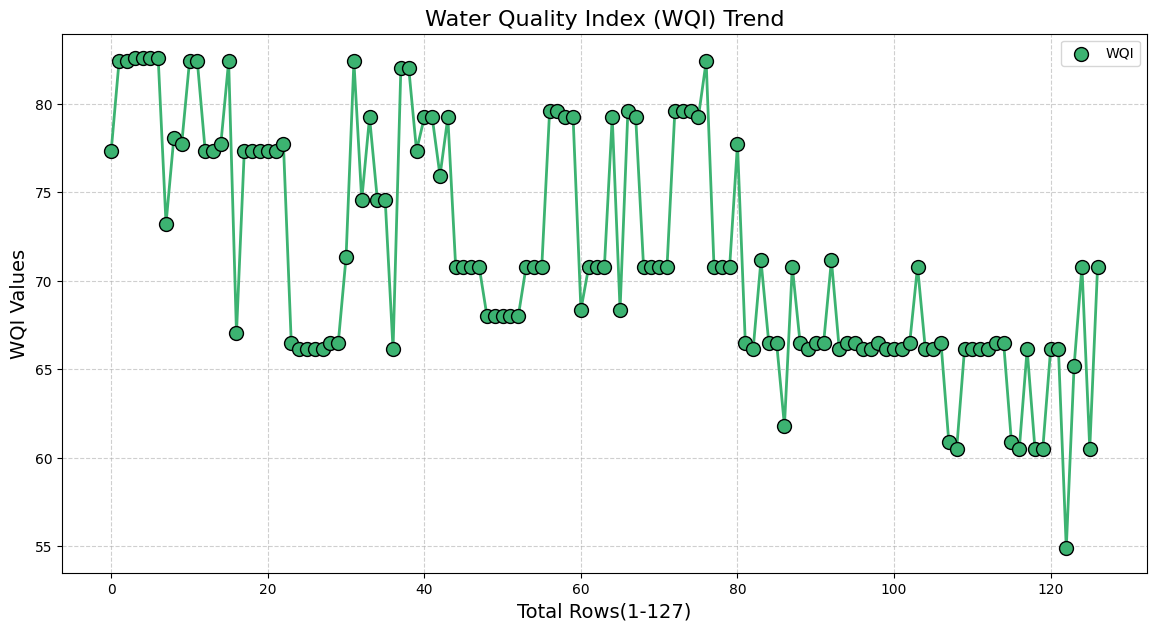

In [29]:

# Create the scatter plot with improved styling
plt.figure(figsize=(14, 7))

# Use a single color for both scatter points and line
color = 'mediumseagreen'

# Scatter plot with customized markers
plt.scatter(df.index, df['WQI'], color=color, edgecolor='black', s=100, zorder=5, label='WQI')
# Line plot with the same color
plt.plot(df.index, df['WQI'], color=color, linewidth=2, linestyle='-', zorder=3)

# Add titles and labels
plt.title('Water Quality Index (WQI) Trend', fontsize=16)
plt.xlabel('Total Rows(1-127)', fontsize=14)
plt.ylabel('WQI Values', fontsize=14)

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.6)

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [30]:
# Function to classify water quality based on WQI
def classify_water_quality(wqi):
    if wqi < 25:
        return 'Poor'
    elif 25 <= wqi < 50:
        return 'Marginal'
    elif 50 <= wqi < 70:
        return 'Medium'
    elif 70 <= wqi < 90:
        return 'Good'
    else:
        return 'Excellent'

# Apply water quality classification to each row in the dataset
df['WaterQuality'] = df['WQI'].apply(classify_water_quality)

In [31]:
df

,DO,Conductivity,BOD (mg/L),Total coliform,Nitrate,PH,WQI,WaterQuality
0,9.100,335.0,3.700,1660,0.815,7.30,77.36,Good
1,9.150,235.0,2.450,1200,0.340,7.30,82.40,Good
2,8.000,250.0,2.850,1300,0.250,7.80,82.40,Good
3,8.375,187.5,2.550,1050,0.350,7.30,82.58,Good
4,8.000,189.0,2.100,510,0.450,7.55,82.58,Good
...,...,...,...,...,...,...,...,...
122,4.800,500.0,3.750,115500,0.350,7.75,54.88,Medium
123,5.700,467.5,2.850,90500,0.500,7.55,65.18,Medium
124,6.150,416.5,2.950,116500,0.415,7.15,70.80,Good
125,5.750,563.5,3.400,115500,3.185,7.60,60.50,Medium


C:\Users\Hp\AppData\Local\Temp\ipykernel_8252\2099147428.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=quality_counts.index, y=quality_counts.values, palette='viridis')


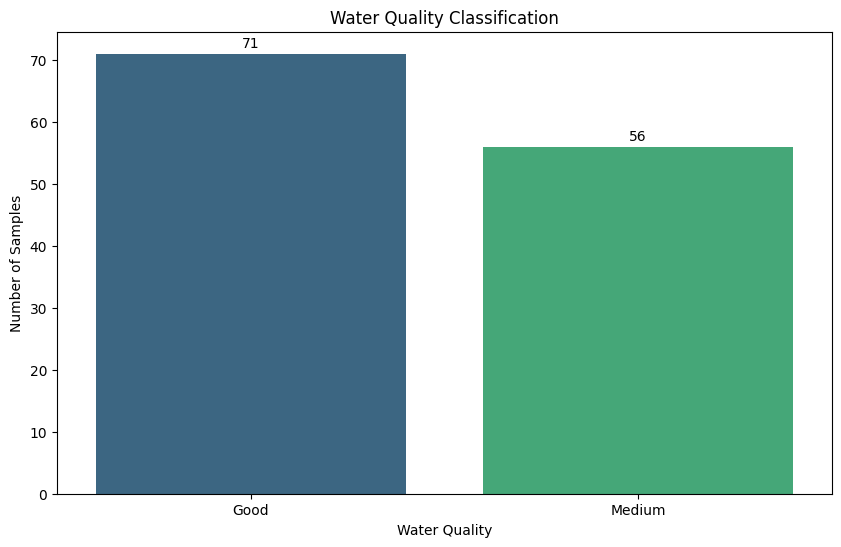

In [32]:


# Apply water quality classification to each row in the dataset
df['WaterQuality'] = df['WQI'].apply(classify_water_quality)

# Filter for Medium and Good classifications
filtered_df = df[df['WaterQuality'].isin(['Medium', 'Good'])]

# Count the occurrences of each classification
quality_counts = filtered_df['WaterQuality'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x=quality_counts.index, y=quality_counts.values, palette='viridis')

# Annotate the bars with the frequency counts
for index, value in enumerate(quality_counts.values):
    bar_plot.text(index, value + 0.5, str(value), ha='center', va='bottom')

plt.title('Water Quality Classification')
plt.xlabel('Water Quality')
plt.ylabel('Number of Samples')
plt.show()

In [33]:
!pip install openpyxl


In [34]:
df.to_excel("df1.xlsx", sheet_name="df1")


In [35]:
# Label encoding for 'WaterQuality'
label_encoder = LabelEncoder()
df['WaterQuality'] = label_encoder.fit_transform(df['WaterQuality'])

# Preloading the dataset (features and target)
X = df.drop(['WQI', 'WaterQuality'], axis=1)
y_wqi = df['WQI']
y_quality = df['WaterQuality']

# Splitting the data into train and test sets for WQI
X_train_wqi, X_test_wqi, y_train_wqi, y_test_wqi = train_test_split(X, y_wqi, test_size=0.2, random_state=42)

# Splitting the data into train and test sets for WaterQuality
X_train_quality, X_test_quality, y_train_quality, y_test_quality = train_test_split(X, y_quality, test_size=0.2, random_state=42)

# Display the shapes of the datasets
print("Shapes for WQI prediction:")
print(f"X_train_wqi: {X_train_wqi.shape}, X_test_wqi: {X_test_wqi.shape}, y_train_wqi: {y_train_wqi.shape}, y_test_wqi: {y_test_wqi.shape}")

print("\nShapes for WaterQuality classification:")
print(f"X_train_quality: {X_train_quality.shape}, X_test_quality: {X_test_quality.shape}, y_train_quality: {y_train_quality.shape}, y_test_quality: {y_test_quality.shape}")

Shapes for WQI prediction:
X_train_wqi: (101, 6), X_test_wqi: (26, 6), y_train_wqi: (101,), y_test_wqi: (26,)

Shapes for WaterQuality classification:
X_train_quality: (101, 6), X_test_quality: (26, 6), y_train_quality: (101,), y_test_quality: (26,)


In [36]:
# KNN for WQI Prediction
knn_regressor = KNeighborsRegressor(7)
knn_regressor.fit(X_train_wqi, y_train_wqi)

# Predictions for training and testing sets
train_preds_wqi = knn_regressor.predict(X_train_wqi)
test_preds_wqi = knn_regressor.predict(X_test_wqi)



# Evaluation metrics for testing set
print("Testing Metrics:")
print(f"R2: {(r2_score(y_test_wqi, test_preds_wqi) * 100):.4f}")
print(f"MAE: {mean_absolute_error(y_test_wqi, test_preds_wqi):.4f}")
print(f"MSE: {mean_squared_error(y_test_wqi, test_preds_wqi):.4f}")

# KNN for WaterQuality Classification
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train_quality, y_train_quality)

# Predictions for training and testing sets
train_preds_quality = knn_classifier.predict(X_train_quality)
test_preds_quality = knn_classifier.predict(X_test_quality)

# Evaluation metrics for testing set
print("Testing Metrics:")
print(f"Accuracy: {accuracy_score(y_test_quality, test_preds_quality):.4f}")
print(f"Precision: {precision_score(y_test_quality, test_preds_quality, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test_quality, test_preds_quality, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test_quality, test_preds_quality, average='weighted'):.4f}")

Testing Metrics:
R2: 82.2059
MAE: 2.0701
MSE: 6.7279
Testing Metrics:
Accuracy: 0.8462
Precision: 0.8846
Recall: 0.8462
F1 Score: 0.8443


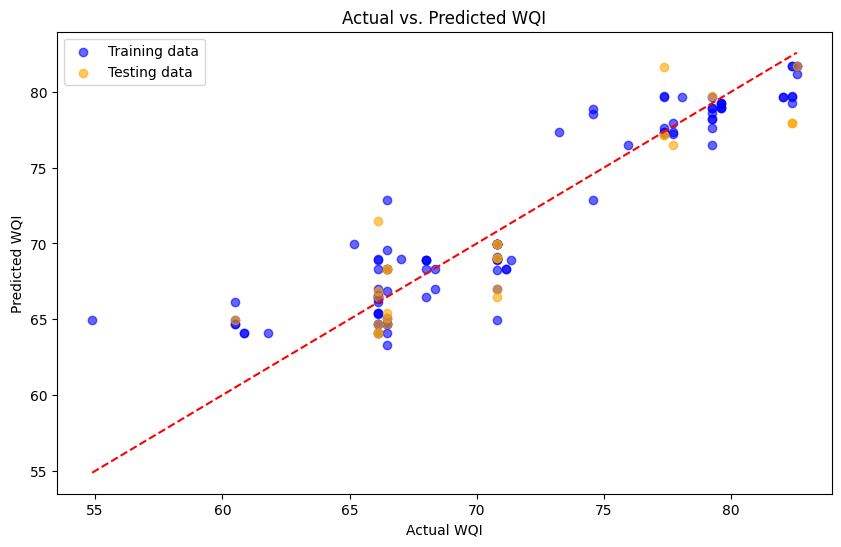

<Figure size 1000x600 with 0 Axes>

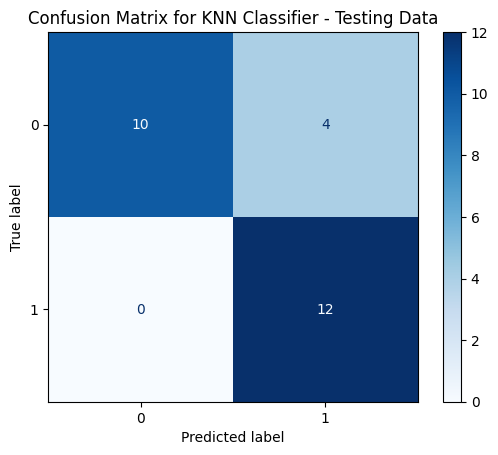

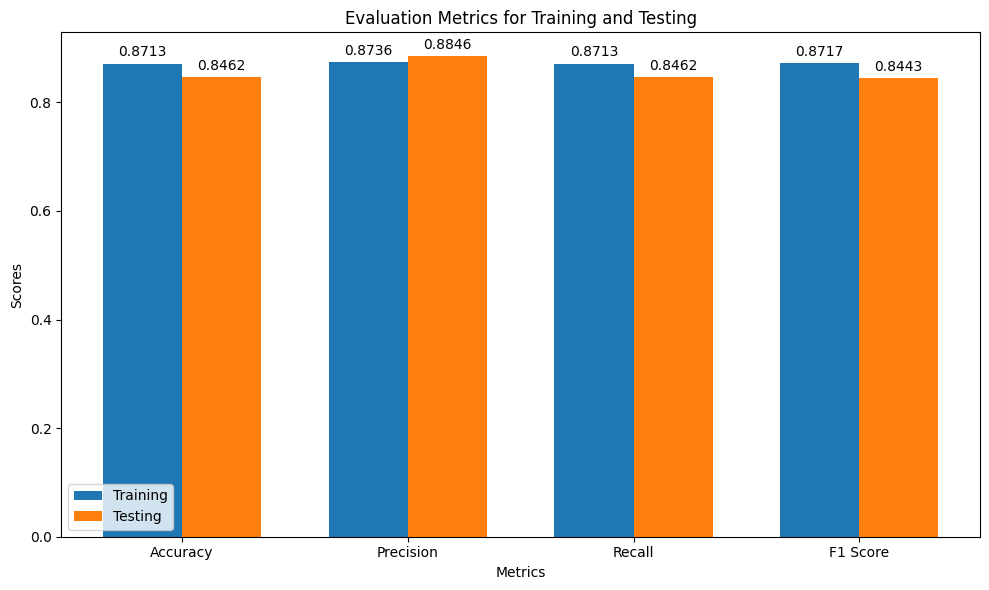

In [37]:
#Knn bar
# Assuming train_preds_wqi and test_preds_wqi are your predictions for the training and testing datasets, respectively
# And y_train_wqi and y_test_wqi are the actual values for the training and testing datasets, respectively

# Actual vs. Predicted Plot for Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_train_wqi, train_preds_wqi, label='Training data', alpha=0.6, color='blue')
plt.scatter(y_test_wqi, test_preds_wqi, label='Testing data', alpha=0.6, color='orange')
plt.plot([min(y_train_wqi.min(), y_test_wqi.min()), max(y_train_wqi.max(), y_test_wqi.max())],
         [min(y_train_wqi.min(), y_test_wqi.min()), max(y_train_wqi.max(), y_test_wqi.max())],
         color='red', linestyle='--')
plt.xlabel('Actual WQI')
plt.ylabel('Predicted WQI')
plt.legend()
plt.title('Actual vs. Predicted WQI')
plt.show()



# Confusion Matrix for Testing
plt.figure(figsize=(10, 6))
ConfusionMatrixDisplay.from_estimator(knn_classifier, X_test_quality, y_test_quality, cmap=plt.cm.Blues)
plt.title('Confusion Matrix for KNN Classifier - Testing Data')
plt.show()
# Calculate metrics for training data
train_preds_quality = knn_classifier.predict(X_train_quality)
train_accuracy = accuracy_score(y_train_quality, train_preds_quality)
train_precision = precision_score(y_train_quality, train_preds_quality, average='weighted')
train_recall = recall_score(y_train_quality, train_preds_quality, average='weighted')
train_f1 = f1_score(y_train_quality, train_preds_quality, average='weighted')


# Calculate metrics for testing data
test_preds_quality = knn_classifier.predict(X_test_quality)
test_accuracy = accuracy_score(y_test_quality, test_preds_quality)
test_precision = precision_score(y_test_quality, test_preds_quality, average='weighted')
test_recall = recall_score(y_test_quality, test_preds_quality, average='weighted')
test_f1 = f1_score(y_test_quality, test_preds_quality, average='weighted')

# Bar chart for metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
train_metrics = [train_accuracy, train_precision, train_recall, train_f1]
test_metrics = [test_accuracy, test_precision, test_recall, test_f1]

x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_metrics, width, label='Training')
rects2 = ax.bar(x + width/2, test_metrics, width, label='Testing')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Evaluation Metrics for Training and Testing')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Attach a text label above each bar in *rects*, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()


In [38]:

# SVM for WQI Prediction
svm_regressor = SVR()
svm_regressor.fit(X_train_wqi, y_train_wqi)

# Predictions for training and testing sets
train_preds_wqi = svm_regressor.predict(X_train_wqi)
test_preds_wqi = svm_regressor.predict(X_test_wqi)

# Evaluation metrics for testing set
print("Testing Metrics:")
print(f"R2: {(r2_score(y_test_wqi, test_preds_wqi)*100):.4f}")
print(f"MAE: {mean_absolute_error(y_test_wqi, test_preds_wqi):.4f}")
print(f"MSE: {mean_squared_error(y_test_wqi, test_preds_wqi):.4f}")

# SVM for WaterQuality Classification
svm_classifier = SVC()
svm_classifier.fit(X_train_quality, y_train_quality)

# Predictions for training and testing sets
train_preds_quality = svm_classifier.predict(X_train_quality)
test_preds_quality = svm_classifier.predict(X_test_quality)


# Evaluation metrics for testing set
print("Testing Metrics:")
print(f"Accuracy: {accuracy_score(y_test_quality, test_preds_quality):.4f}")
print(f"Precision: {precision_score(y_test_quality, test_preds_quality, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test_quality, test_preds_quality, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test_quality, test_preds_quality, average='weighted'):.4f}")

Testing Metrics:
R2: 45.4213
MAE: 3.3562
MSE: 20.6360
Testing Metrics:
Accuracy: 0.8077
Precision: 0.8220
Recall: 0.8077
F1 Score: 0.8033


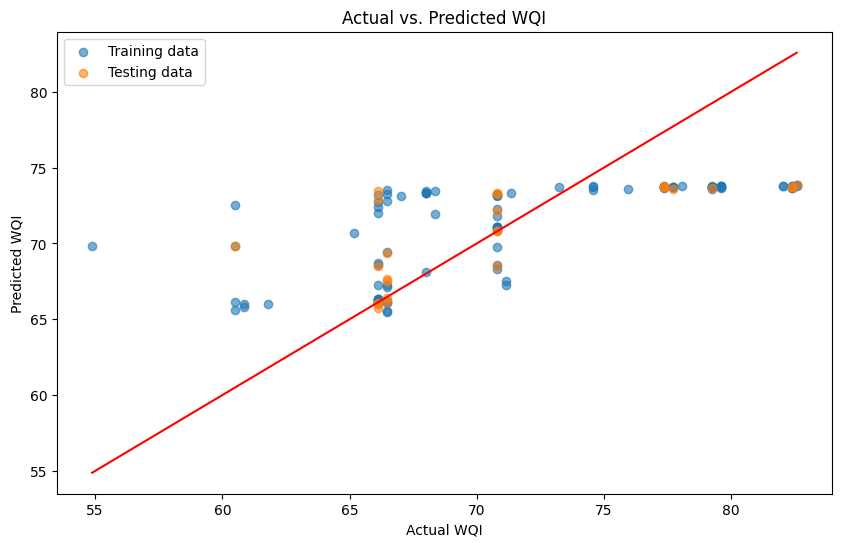

<Figure size 1000x600 with 0 Axes>

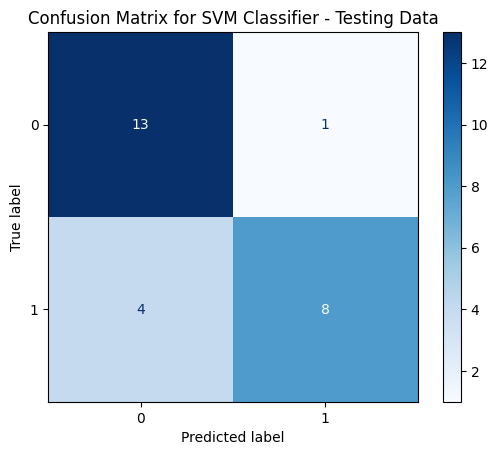

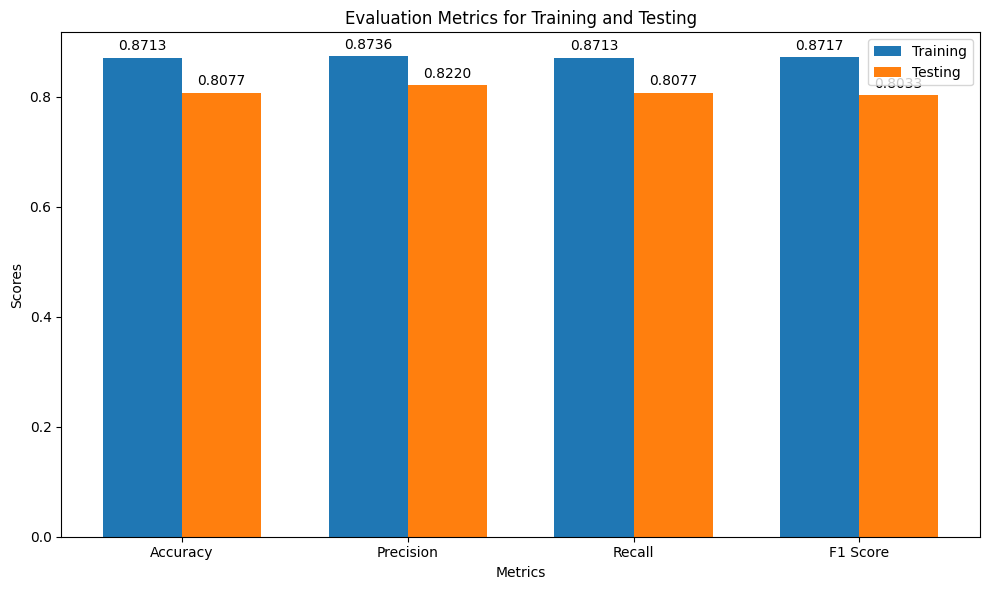

In [39]:
#SVM bar
# Actual vs. Predicted Plot for Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_train_wqi, train_preds_wqi, label='Training data', alpha=0.6)
plt.scatter(y_test_wqi, test_preds_wqi, label='Testing data', alpha=0.6)
plt.plot([min(y_train_wqi), max(y_train_wqi)], [min(y_train_wqi), max(y_train_wqi)], color='red')
plt.xlabel('Actual WQI')
plt.ylabel('Predicted WQI')
plt.legend()
plt.title('Actual vs. Predicted WQI')
plt.show()


# Confusion Matrix for Testing
plt.figure(figsize=(10, 6))
ConfusionMatrixDisplay.from_estimator(svm_classifier, X_test_quality, y_test_quality, cmap=plt.cm.Blues)
plt.title('Confusion Matrix for SVM Classifier - Testing Data')
plt.show()

# Calculate metrics for testing data
test_preds_quality = svm_classifier.predict(X_test_quality)
test_accuracy = accuracy_score(y_test_quality, test_preds_quality)
test_precision = precision_score(y_test_quality, test_preds_quality, average='weighted')
test_recall = recall_score(y_test_quality, test_preds_quality, average='weighted')
test_f1 = f1_score(y_test_quality, test_preds_quality, average='weighted')

# Bar chart for metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
train_metrics = [train_accuracy, train_precision, train_recall, train_f1]
test_metrics = [test_accuracy, test_precision, test_recall, test_f1]

x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_metrics, width, label='Training')
rects2 = ax.bar(x + width/2, test_metrics, width, label='Testing')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Evaluation Metrics for Training and Testing')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Attach a text label above each bar in *rects*, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()



In [40]:
#multi lIinear Reression
# Assuming X_train_wqi, X_test_wqi, y_train_wqi, y_test_wqi, X_train_quality, X_test_quality, y_train_quality, y_test_quality are already defined

# Standardize the features
scaler_wqi = StandardScaler()
X_train_wqi_scaled = scaler_wqi.fit_transform(X_train_wqi)
X_test_wqi_scaled = scaler_wqi.transform(X_test_wqi)

# Feature Selection using Recursive Feature Elimination (RFE)
selector = RFE(estimator=LinearRegression(), n_features_to_select=10, step=1)
selector = selector.fit(X_train_wqi_scaled, y_train_wqi)
X_train_wqi_selected = selector.transform(X_train_wqi_scaled)
X_test_wqi_selected = selector.transform(X_test_wqi_scaled)

# Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_wqi_poly = poly.fit_transform(X_train_wqi_selected)
X_test_wqi_poly = poly.transform(X_test_wqi_selected)

# Regularization (Ridge and Lasso Regression)
# Hyperparameter tuning using GridSearchCV

# Multivariate Linear Regression
ridge = Ridge()
param_grid_ridge = {'alpha': np.logspace(-6, 6, 13)}
grid_search_ridge = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error')
grid_search_ridge.fit(X_train_wqi_poly, y_train_wqi)
best_ridge = grid_search_ridge.best_estimator_


# Evaluate the best Ridge and Lasso models on the testing set
ridge_train_preds = best_ridge.predict(X_train_wqi_poly)
ridge_test_preds = best_ridge.predict(X_test_wqi_poly)



print("Multivariate Linear Regression Model:")

print("Testing Metrics:")
print(f"R2: {r2_score(y_test_wqi, ridge_test_preds)*100:.4f}")
print(f"MAE: {mean_absolute_error(y_test_wqi, ridge_test_preds):.4f}")
print(f"MSE: {mean_squared_error(y_test_wqi, ridge_test_preds):.4f}")



C:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_rfe.py:291: UserWarning: Found n_features_to_select=10 > n_features=6. There will be no feature selection and all features will be kept.
  warnings.warn(


Multivariate Linear Regression Model:
Testing Metrics:
R2: 45.1635
MAE: 3.8735
MSE: 20.7335


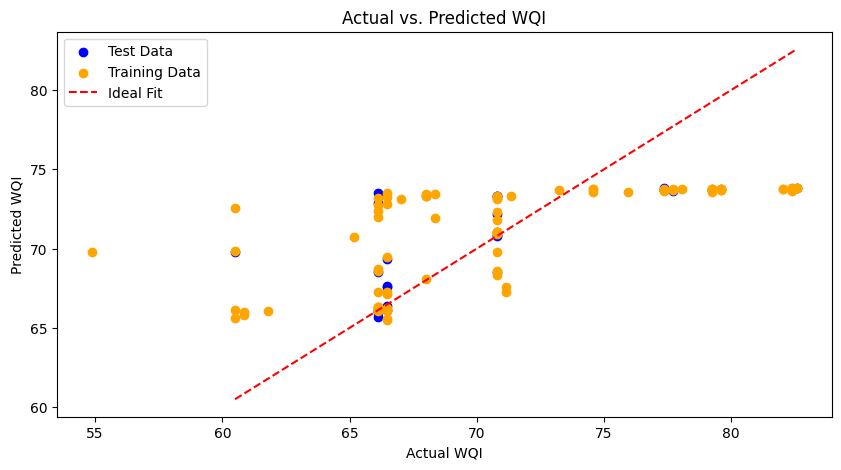

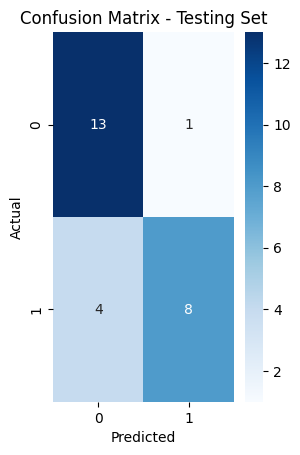

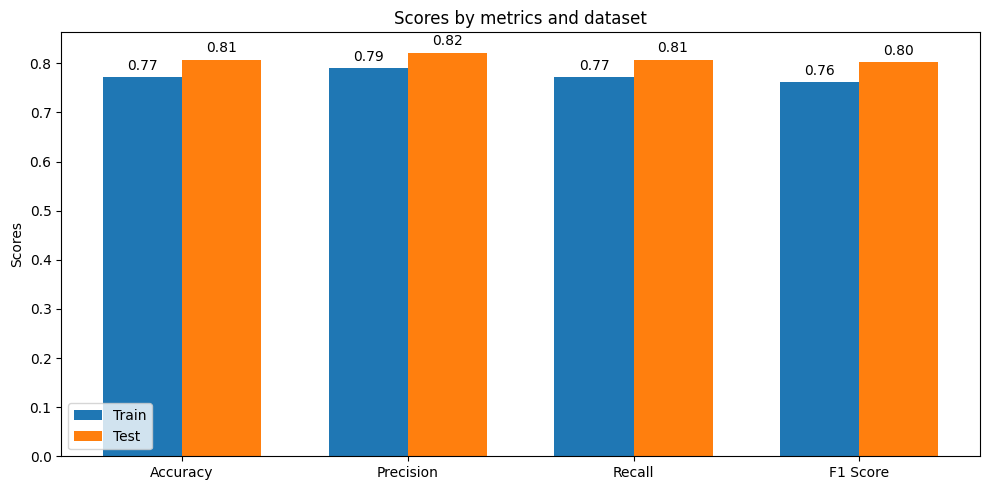

In [41]:
# Actual vs. Predicted graph for Multivariate Linear Regression
plt.figure(figsize=(10, 5))
plt.scatter(y_test_wqi, test_preds_wqi, color='blue', label='Test Data')
plt.scatter(y_train_wqi, train_preds_wqi, color='orange', label='Training Data')
plt.plot([min(y_test_wqi), max(y_test_wqi)], [min(y_test_wqi), max(y_test_wqi)], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual WQI')
plt.ylabel('Predicted WQI')
plt.title('Actual vs. Predicted WQI')
plt.legend()
plt.show()

# Confusion Matrix for Logistic Regression
train_cm = confusion_matrix(y_train_quality, train_preds_quality)
test_cm = confusion_matrix(y_test_quality, test_preds_quality)


# Plotting Confusion Matrix for Testing Set
plt.subplot(1, 2, 2)
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Testing Set')

plt.show()

# Bar chart for accuracy, precision, recall, and F1 score for Logistic Regression
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
train_scores = [accuracy_score(y_train_quality, train_preds_quality),
                precision_score(y_train_quality, train_preds_quality, average='weighted'),
                recall_score(y_train_quality, train_preds_quality, average='weighted'),
                f1_score(y_train_quality, train_preds_quality, average='weighted')]

test_scores = [accuracy_score(y_test_quality, test_preds_quality),
               precision_score(y_test_quality, test_preds_quality, average='weighted'),
               recall_score(y_test_quality, test_preds_quality, average='weighted'),
               f1_score(y_test_quality, test_preds_quality, average='weighted')]

x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - width/2, train_scores, width, label='Train')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by metrics and dataset')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Attach a text label above each bar in rects, displaying its height.
def autolabel(rects):
    """Attach a text label above each bar in rects, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [42]:
#random Forest


# Define a pipeline for Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42)
param_grid_rf = {
    'max_depth': [3, 5],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [4, 6],
    'n_estimators': [50, 75]
}

grid_search_rf = GridSearchCV(rf_regressor, param_grid_rf, cv=5, scoring='r2')
grid_search_rf.fit(X_train_wqi_scaled, y_train_wqi)

# Get the best model from grid search
best_rf_regressor = grid_search_rf.best_estimator_



# Testing metrics for Random Forest Regressor
test_preds_wqi_rf = best_rf_regressor.predict(X_test_wqi_scaled)
test_r2_rf = r2_score(y_test_wqi, test_preds_wqi_rf) * 100
test_mae_rf = mean_absolute_error(y_test_wqi, test_preds_wqi_rf)
test_mse_rf = mean_squared_error(y_test_wqi, test_preds_wqi_rf)

print("Testing Metrics:")
print(f"R2: {test_r2_rf:.4f}")
print(f"MAE: {test_mae_rf:.4f}")
print(f"MSE: {test_mse_rf:.4f}")

# Define a pipeline for Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
param_grid_rf_clf = {
    'max_depth': [3, 5],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [4, 6],
    'n_estimators': [50, 75]
}

grid_search_rf_clf = GridSearchCV(rf_classifier, param_grid_rf_clf, cv=5, scoring='accuracy')
grid_search_rf_clf.fit(X_train_quality, y_train_quality)

# Get the best model from grid search
best_rf_classifier = grid_search_rf_clf.best_estimator_



# Testing metrics for Random Forest Classifier
test_preds_quality_rf = best_rf_classifier.predict(X_test_quality)
print("Testing Metrics:")
print(f"Accuracy: {accuracy_score(y_test_quality, test_preds_quality_rf):.4f}")
print(f"Precision: {precision_score(y_test_quality, test_preds_quality_rf, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test_quality, test_preds_quality_rf, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test_quality, test_preds_quality_rf, average='weighted'):.4f}")

# Create a DataFrame to show Actual vs Predicted WQI values
wqi_comparison = pd.DataFrame({
    'Row Number': range(len(y_test_wqi)),
    'Actual WQI': y_test_wqi,
    'Predicted WQI (Random Forest)': test_preds_wqi_rf
})

Testing Metrics:
R2: 94.5030
MAE: 0.7514
MSE: 2.0784
Testing Metrics:
Accuracy: 0.9615
Precision: 0.9641
Recall: 0.9615
F1 Score: 0.9614


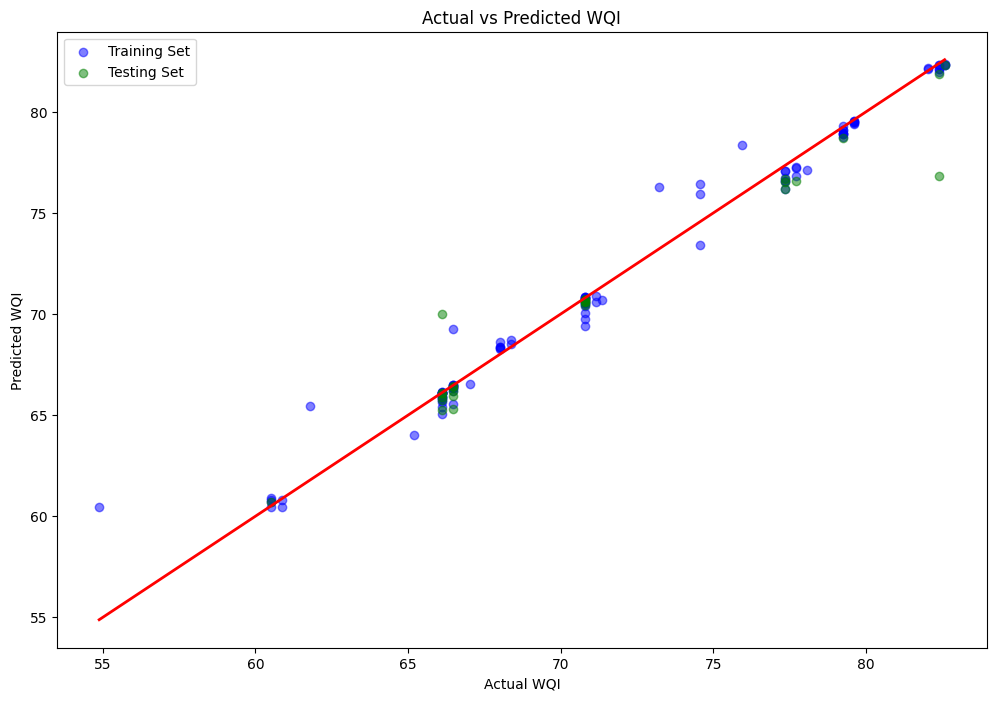

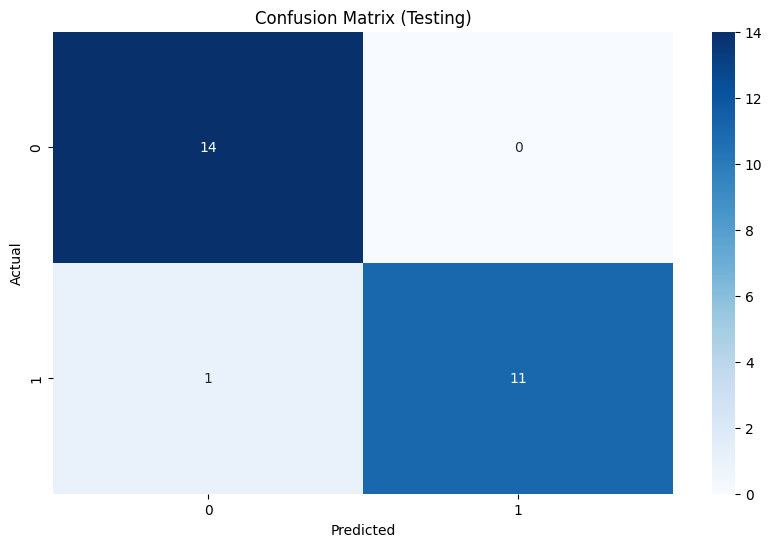

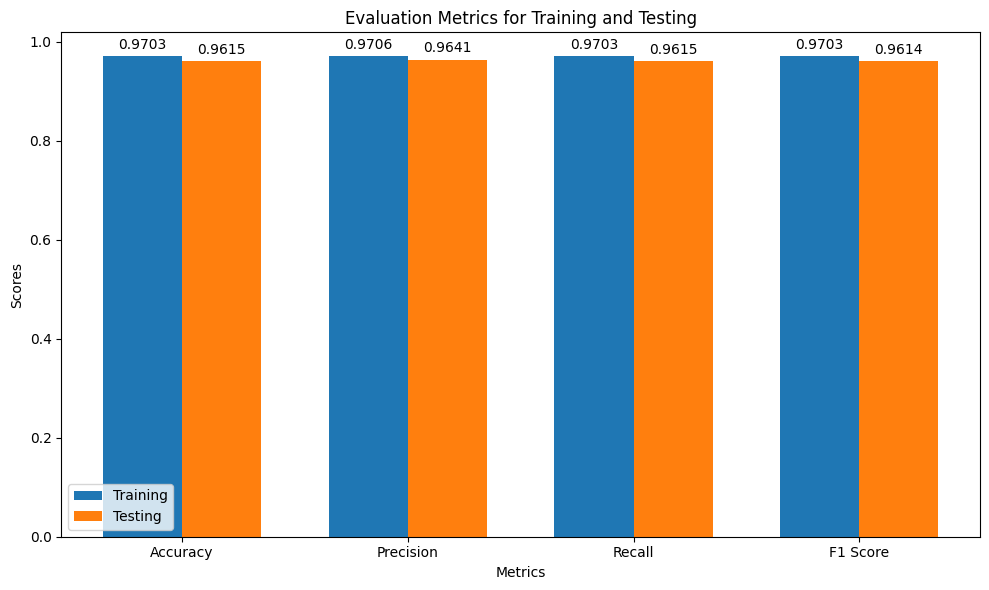

In [43]:
#random forest bar

# Assuming X and y are already defined
# Example splitting the data into training and testing sets
X_train_wqi, X_test_wqi, y_train_wqi, y_test_wqi = train_test_split(X, y_wqi, test_size=0.2, random_state=42)
X_train_quality, X_test_quality, y_train_quality, y_test_quality = train_test_split(X, y_quality, test_size=0.2, random_state=42)

# Standardize the features
scaler_wqi = StandardScaler()
X_train_wqi_scaled = scaler_wqi.fit_transform(X_train_wqi)
X_test_wqi_scaled = scaler_wqi.transform(X_test_wqi)

# Define and fit a Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
param_grid_rf_clf = {
    'max_depth': [3, 5],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [4, 6],
    'n_estimators': [50, 75]
}

grid_search_rf_clf = GridSearchCV(rf_classifier, param_grid_rf_clf, cv=5, scoring='accuracy')
grid_search_rf_clf.fit(X_train_quality, y_train_quality)

# Get the best model from grid search
best_rf_classifier = grid_search_rf_clf.best_estimator_

# Calculate metrics for training data
train_preds_quality_rf = best_rf_classifier.predict(X_train_quality)
train_accuracy_rf = accuracy_score(y_train_quality, train_preds_quality_rf)
train_precision_rf = precision_score(y_train_quality, train_preds_quality_rf, average='weighted')
train_recall_rf = recall_score(y_train_quality, train_preds_quality_rf, average='weighted')
train_f1_rf = f1_score(y_train_quality, train_preds_quality_rf, average='weighted')

# Calculate metrics for testing data
test_preds_quality_rf = best_rf_classifier.predict(X_test_quality)
test_accuracy_rf = accuracy_score(y_test_quality, test_preds_quality_rf)
test_precision_rf = precision_score(y_test_quality, test_preds_quality_rf, average='weighted')
test_recall_rf = recall_score(y_test_quality, test_preds_quality_rf, average='weighted')
test_f1_rf = f1_score(y_test_quality, test_preds_quality_rf, average='weighted')
# Assuming best_rf_regressor is defined and trained as per your earlier code
# Plot Actual vs. Predicted for Training and Testing Set
train_preds_wqi = best_rf_regressor.predict(X_train_wqi_scaled)
test_preds_wqi = best_rf_regressor.predict(X_test_wqi_scaled)

plt.figure(figsize=(12, 8))
# Training set
plt.scatter(y_train_wqi, train_preds_wqi, color='blue', alpha=0.5, label='Training Set')
# Testing set
plt.scatter(y_test_wqi, test_preds_wqi, color='green', alpha=0.5, label='Testing Set')

# Line of best fit
plt.plot([min(y_train_wqi.min(), y_test_wqi.min()), max(y_train_wqi.max(), y_test_wqi.max())],
         [min(y_train_wqi.min(), y_test_wqi.min()), max(y_train_wqi.max(), y_test_wqi.max())],
         color='red', linewidth=2)

plt.xlabel('Actual WQI')
plt.ylabel('Predicted WQI')
plt.title('Actual vs Predicted WQI')
plt.legend()
plt.show()

# Plot confusion matrix for testing data
test_conf_matrix = confusion_matrix(y_test_quality, test_preds_quality_rf)
plt.figure(figsize=(10, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Testing)')
plt.show()

# Plotting bar chart for evaluation metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
train_metrics_rf = [train_accuracy_rf, train_precision_rf, train_recall_rf, train_f1_rf]
test_metrics_rf = [test_accuracy_rf, test_precision_rf, test_recall_rf, test_f1_rf]

x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_metrics_rf, width, label='Training')
rects2 = ax.bar(x + width/2, test_metrics_rf, width, label='Testing')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Evaluation Metrics for Training and Testing')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Attach a text label above each bar in rects, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()



In [44]:

# Decision Tree for WQI Prediction
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_train_wqi, y_train_wqi)

# Predictions for training and testing sets
train_preds_wqi = dt_regressor.predict(X_train_wqi)
test_preds_wqi = dt_regressor.predict(X_test_wqi)

# Evaluation metrics for testing set
print("Testing Metrics:")
print(f"R2: {(r2_score(y_test_wqi, test_preds_wqi)*100):.4f}")
print(f"MAE: {mean_absolute_error(y_test_wqi, test_preds_wqi):.4f}")
print(f"MSE: {mean_squared_error(y_test_wqi, test_preds_wqi):.4f}")

# Decision Tree for WaterQuality Classification
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_quality, y_train_quality)

# Predictions for training and testing sets
train_preds_quality = dt_classifier.predict(X_train_quality)
test_preds_quality = dt_classifier.predict(X_test_quality)



# Evaluation metrics for testing set
print("Testing Metrics:")
print(f"Accuracy: {accuracy_score(y_test_quality, test_preds_quality):.4f}")
print(f"Precision: {precision_score(y_test_quality, test_preds_quality, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test_quality, test_preds_quality, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test_quality, test_preds_quality, average='weighted'):.4f}")


Testing Metrics:
R2: 90.9593
MAE: 0.7115
MSE: 3.4182
Testing Metrics:
Accuracy: 0.9615
Precision: 0.9641
Recall: 0.9615
F1 Score: 0.9614


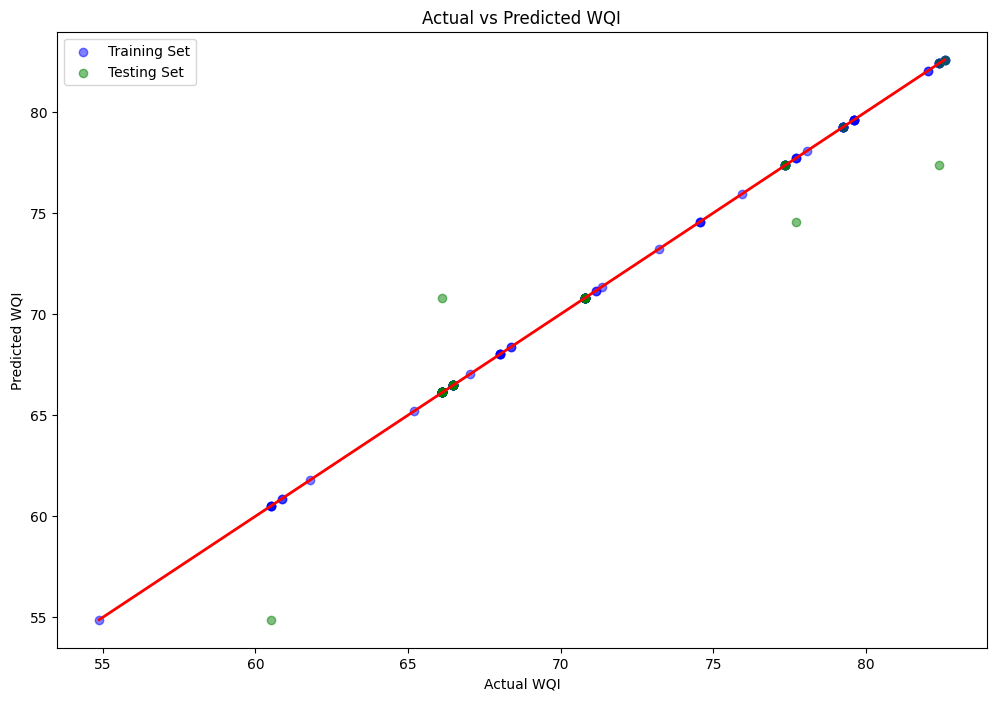

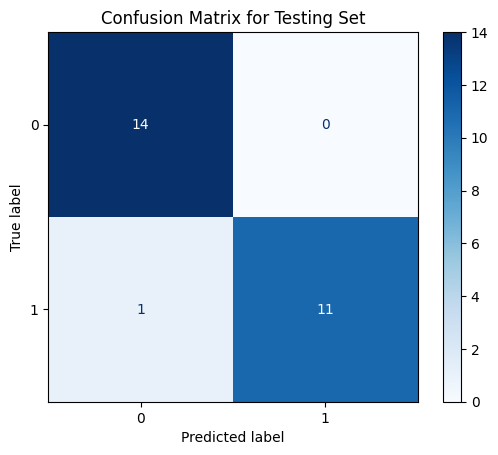

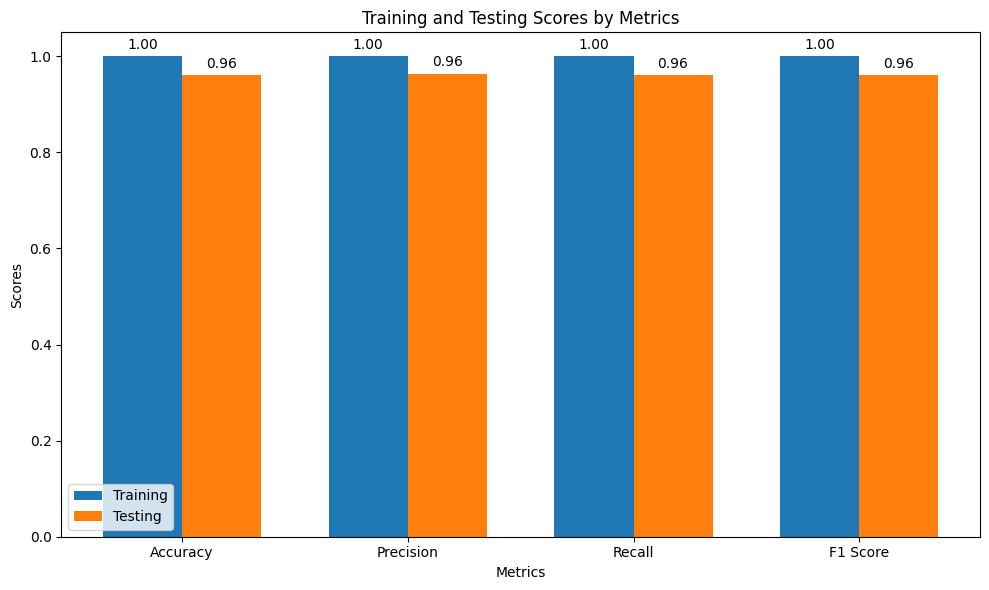

In [45]:
# Actual vs. Predicted for decesion Tree Training and Testing Set (WQI Regression)
plt.figure(figsize=(12, 8))

# Training set
plt.scatter(y_train_wqi, train_preds_wqi, color='blue', alpha=0.5, label='Training Set')
# Testing set
plt.scatter(y_test_wqi, test_preds_wqi, color='green', alpha=0.5, label='Testing Set')

# Line of best fit
plt.plot([min(y_train_wqi.min(), y_test_wqi.min()), max(y_train_wqi.max(), y_test_wqi.max())],
         [min(y_train_wqi.min(), y_test_wqi.min()), max(y_train_wqi.max(), y_test_wqi.max())],
         color='red', linewidth=2)

plt.xlabel('Actual WQI')
plt.ylabel('Predicted WQI')
plt.title('Actual vs Predicted WQI')
plt.legend()
plt.show()




# Confusion Matrix for Testing Set
cm_test = confusion_matrix(y_test_quality, test_preds_quality)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Testing Set')
plt.show()

# Store evaluation metrics in lists
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

training_scores = [
    accuracy_score(y_train_quality, train_preds_quality),
    precision_score(y_train_quality, train_preds_quality, average='weighted'),
    recall_score(y_train_quality, train_preds_quality, average='weighted'),
    f1_score(y_train_quality, train_preds_quality, average='weighted')
]

testing_scores = [
    accuracy_score(y_test_quality, test_preds_quality),
    precision_score(y_test_quality, test_preds_quality, average='weighted'),
    recall_score(y_test_quality, test_preds_quality, average='weighted'),
    f1_score(y_test_quality, test_preds_quality, average='weighted')
]

x = np.arange(len(metrics))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, training_scores, width, label='Training')
bars2 = ax.bar(x + width/2, testing_scores, width, label='Testing')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Training and Testing Scores by Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Attach a text label above each bar in *bars*, displaying its height.
def autolabel(bars):
    """Attach a text label above each bar in *bars*, displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

fig.tight_layout()

plt.show()


In [46]:
import pandas as pd

# Define the testing metrics for each model
models = [
    "KNN Regressor",
    "SVM Regressor",
    "Multivariate Linear Regression",
    "Random Forest Regressor",
    "Decision Tree Regressor"
]

r2_scores = [
    82.7722,
    45.4213,
    45.1635,
    94.5030,
    90.9593
]

mae_scores = [
    2.0646,
    3.3562,
    3.8735,
    0.7514,
    0.7115
]

mse_scores = [
    6.5137,
    20.6360,
    20.7335,
    2.0784,
    3.4182
]

# Create a DataFrame with the above data
df = pd.DataFrame({
    "Model": models,
    "R2": r2_scores,
    "MAE": mae_scores,
    "MSE": mse_scores
})

# Print the DataFrame
print(df)

# If using Jupyter Notebook or similar, display the DataFrame
try:
    from IPython.display import display
    display(df)
except ImportError:
    pass


                            Model       R2     MAE      MSE
0                   KNN Regressor  82.7722  2.0646   6.5137
1                   SVM Regressor  45.4213  3.3562  20.6360
2  Multivariate Linear Regression  45.1635  3.8735  20.7335
3         Random Forest Regressor  94.5030  0.7514   2.0784
4         Decision Tree Regressor  90.9593  0.7115   3.4182


,Model,R2,MAE,MSE
0,KNN Regressor,82.7722,2.0646,6.5137
1,SVM Regressor,45.4213,3.3562,20.6360
2,Multivariate Linear Regression,45.1635,3.8735,20.7335
3,Random Forest Regressor,94.5030,0.7514,2.0784
4,Decision Tree Regressor,90.9593,0.7115,3.4182


From these metrics, Random Forest Regressor is the best model for WQI prediction. It has the highest R2 score (94.5030), the lowest MAE (0.7514), and the lowest MSE (2.0784). This indicates that the Random Forest Regressor provides the best fit and most accurate predictions for your dataset among the models evaluated.


In [47]:
import pandas as pd

# Data for the table
data = {
    'Model': [
        'KNN Classifier',
        'SVM Classifier',
        'Random Forest Classifier',
        'Decision Tree Classifier'
    ],
    'Accuracy': [
        0.8462,
        0.8077,
        0.9615,
        0.9615
    ],
    'Precision': [
        0.8846,
        0.8220,
        0.9641,
        0.9641
    ],
    'Recall': [
        0.8462,
        0.8077,
        0.9615,
        0.9615
    ],
    'F1 Score': [
        0.8443,
        0.8033,
        0.9614,
        0.9614
    ]
}

# Creating the DataFrame
df = pd.DataFrame(data)

# Displaying the table
print(df)


                      Model  Accuracy  Precision  Recall  F1 Score
0            KNN Classifier    0.8462     0.8846  0.8462    0.8443
1            SVM Classifier    0.8077     0.8220  0.8077    0.8033
2  Random Forest Classifier    0.9615     0.9641  0.9615    0.9614
3  Decision Tree Classifier    0.9615     0.9641  0.9615    0.9614


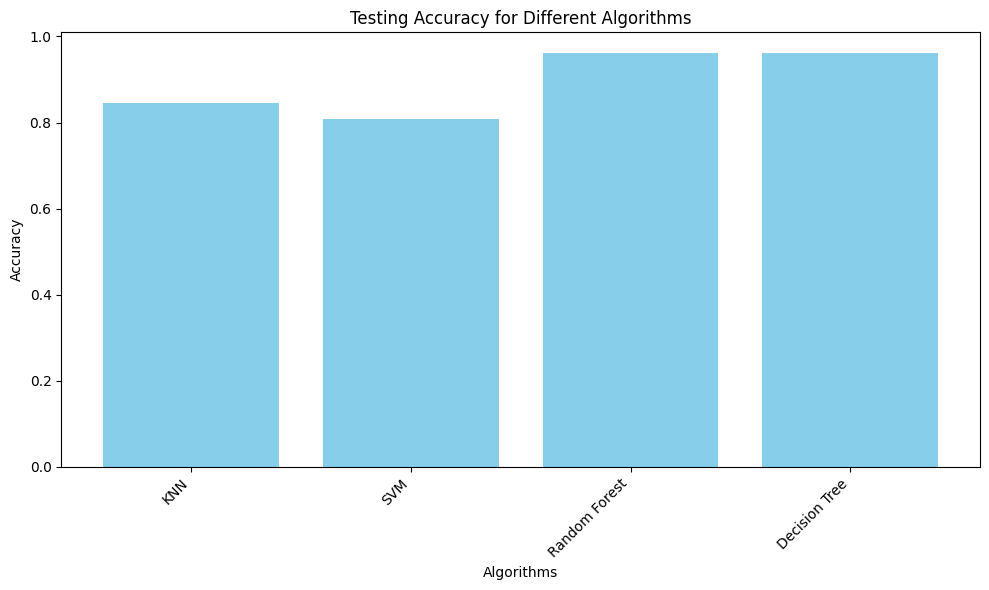

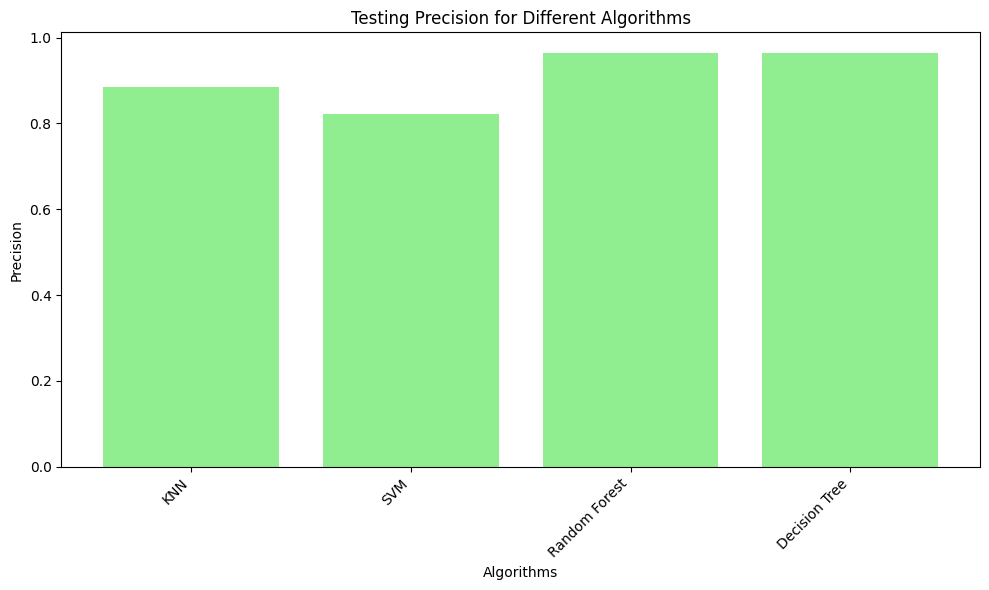

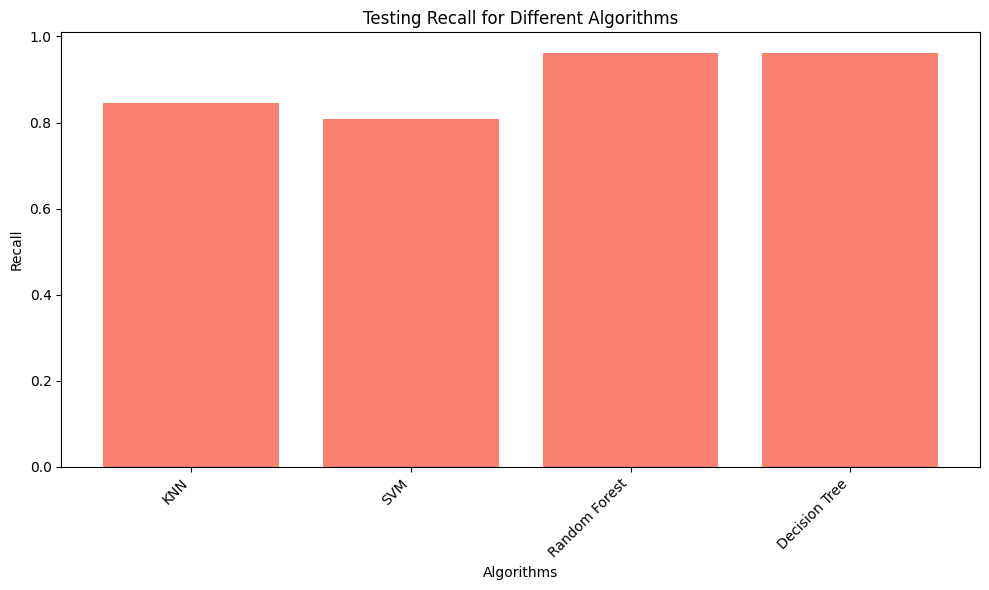

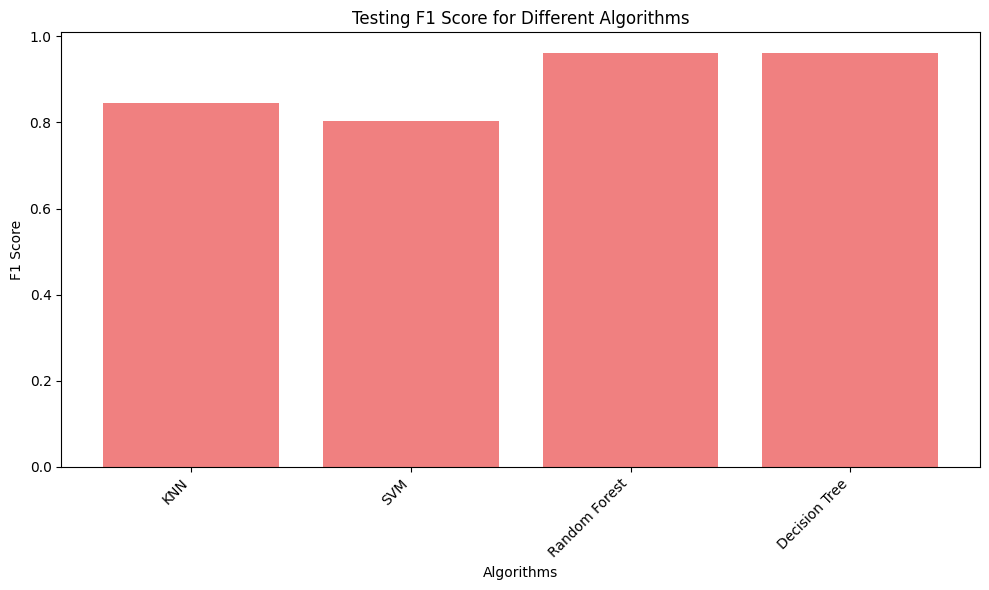

In [48]:
import matplotlib.pyplot as plt

# Define the algorithms
algorithms = ['KNN', 'SVM', 'Random Forest', 'Decision Tree']

# Define the testing metrics for each algorithm
accuracy_scores = [0.8462, 0.8077, 0.9615, 0.9615]
precision_scores = [0.8846, 0.8220, 0.9641, 0.9641]
recall_scores = [0.8462, 0.8077, 0.9615, 0.9615]
f1_scores = [0.8443, 0.8033, 0.9614, 0.9614]

# Plotting accuracy
plt.figure(figsize=(10, 6))
plt.bar(algorithms, accuracy_scores, color='skyblue')
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy for Different Algorithms')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plotting precision
plt.figure(figsize=(10, 6))
plt.bar(algorithms, precision_scores, color='lightgreen')
plt.xlabel('Algorithms')
plt.ylabel('Precision')
plt.title('Testing Precision for Different Algorithms')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plotting recall
plt.figure(figsize=(10, 6))
plt.bar(algorithms, recall_scores, color='salmon')
plt.xlabel('Algorithms')
plt.ylabel('Recall')
plt.title('Testing Recall for Different Algorithms')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plotting F1 score
plt.figure(figsize=(10, 6))
plt.bar(algorithms, f1_scores, color='lightcoral')
plt.xlabel('Algorithms')
plt.ylabel('F1 Score')
plt.title('Testing F1 Score for Different Algorithms')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

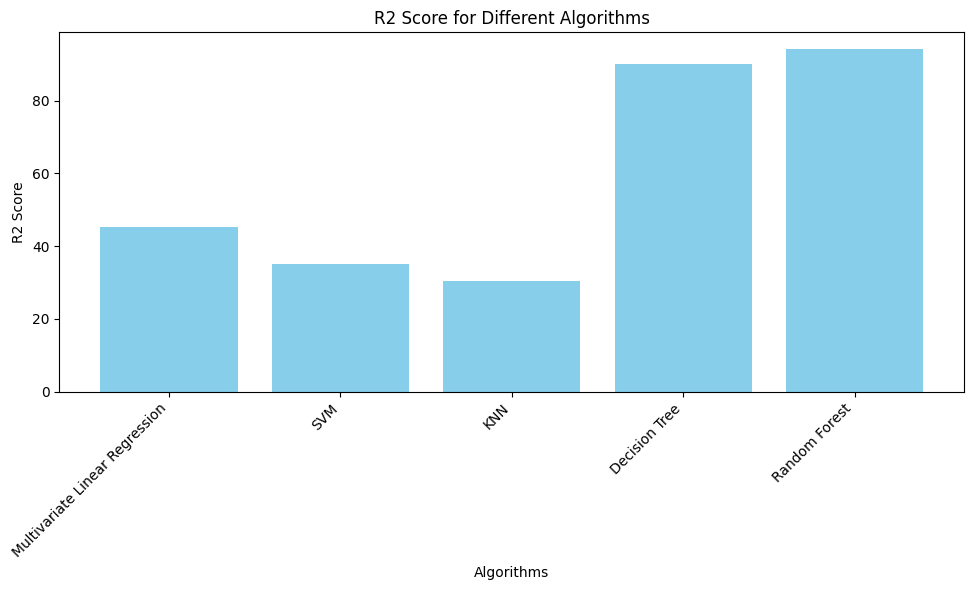

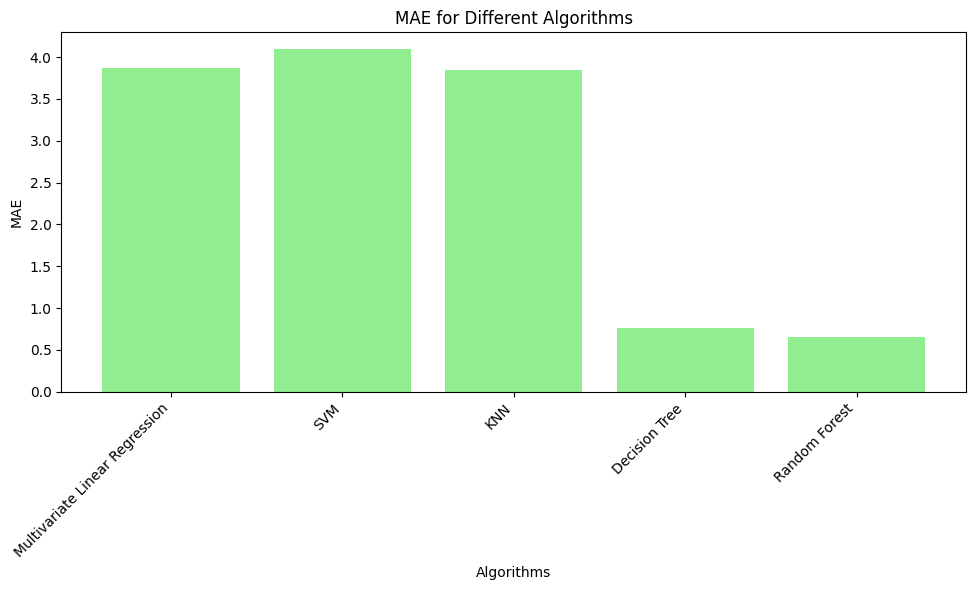

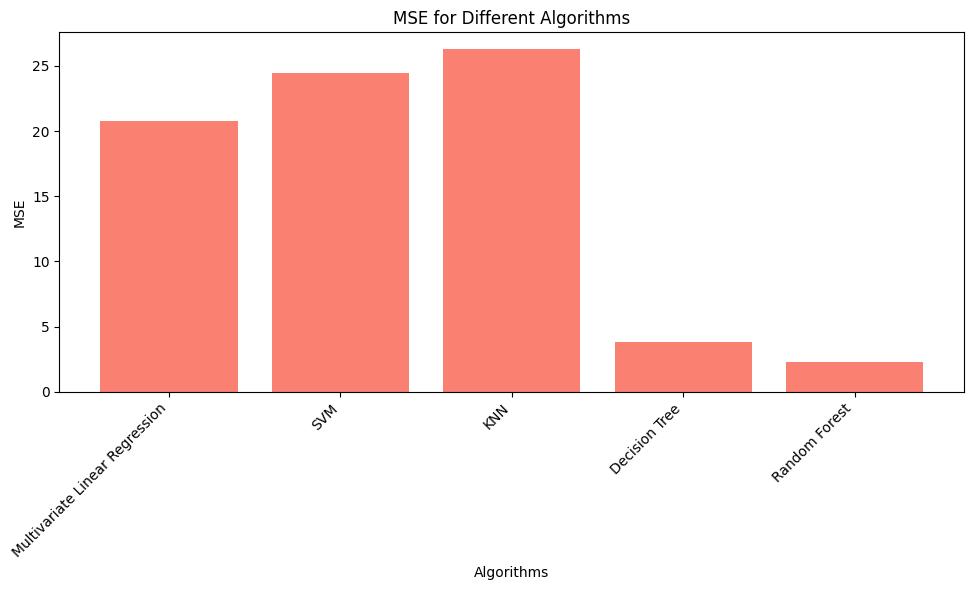

In [49]:


# Define the algorithms
algorithms = ['Multivariate Linear Regression', 'SVM', 'KNN', 'Decision Tree', 'Random Forest']

# Define the testing metrics for each algorithm
r2_scores = [45.1635, 35.2248, 30.5440, 89.9152, 94.0460]
mae_scores = [3.8735, 4.0919, 3.8411, 0.7631, 0.6572]
mse_scores = [20.7335, 24.4912, 26.2610, 3.8130, 2.2512]

# Plotting R2
plt.figure(figsize=(10, 6))
plt.bar(algorithms, r2_scores, color='skyblue')
plt.xlabel('Algorithms')
plt.ylabel('R2 Score')
plt.title('R2 Score for Different Algorithms')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plotting MAE
plt.figure(figsize=(10, 6))
plt.bar(algorithms, mae_scores, color='lightgreen')
plt.xlabel('Algorithms')
plt.ylabel('MAE')
plt.title('MAE for Different Algorithms')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plotting MSE
plt.figure(figsize=(10, 6))
plt.bar(algorithms, mse_scores, color='salmon')
plt.xlabel('Algorithms')
plt.ylabel('MSE')
plt.title('MSE for Different Algorithms')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Evaluation Metrics for Testing Phase:

Multivariate Linear Regression:
R2: -279.2412
MAE: 7.0306
MSE: 143.3894

SVM:
R2: 35.2248
MAE: 4.0919
MSE: 24.4912

KNN:
R2: 30.5440
MAE: 3.8411
MSE: 26.2610

Decision Tree:
R2: 89.9152
MAE: 0.7631
MSE: 3.8130

Random Forest:
R2: 93.8104
MAE: 0.6914
MSE: 2.3403

Actual vs Predicted WQI values:
     Row Number  Actual WQI  Multivariate Linear Regression        SVM  \
26            0       66.12                       70.184321  69.703312   
111           1       66.12                       59.603129  69.023971   
81            2       66.48                       65.018272  66.145008   
55            3       70.80                       72.092033  71.120111   
44            4       70.80                       16.598184  69.817365   
96            5       66.12                       57.662268  69.160877   
80            6       77.72                       69.267287  69.023434   
125           7       60.50                       54.739984  69.562543   


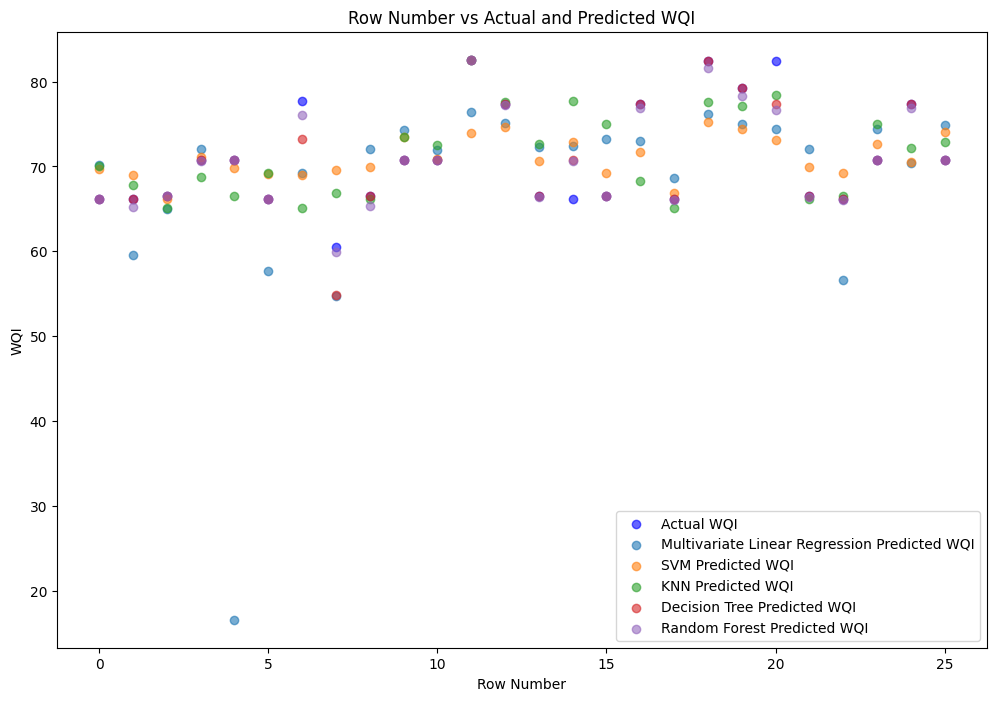

In [50]:


# Assuming X_train_wqi, X_test_wqi, y_train_wqi, y_test_wqi are already defined

# Scaling the data
scaler = StandardScaler()
X_train_wqi_scaled = scaler.fit_transform(X_train_wqi)
X_test_wqi_scaled = scaler.transform(X_test_wqi)

# Multivariate Linear Regression for WQI Prediction (same as Linear Regression)
linear_regressor = LinearRegression()
linear_regressor.fit(X_train_wqi_scaled, y_train_wqi)
test_preds_wqi_lr = linear_regressor.predict(X_test_wqi_scaled)

# SVM for WQI Prediction
svm_regressor = SVR()
svm_regressor.fit(X_train_wqi_scaled, y_train_wqi)
test_preds_wqi_svm = svm_regressor.predict(X_test_wqi_scaled)

# KNN for WQI Prediction
knn_regressor = KNeighborsRegressor()
knn_regressor.fit(X_train_wqi_scaled, y_train_wqi)
test_preds_wqi_knn = knn_regressor.predict(X_test_wqi_scaled)

# Decision Tree for WQI Prediction
dt_regressor = DecisionTreeRegressor()
dt_regressor.fit(X_train_wqi_scaled, y_train_wqi)
test_preds_wqi_dt = dt_regressor.predict(X_test_wqi_scaled)

# Random Forest for WQI Prediction
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train_wqi_scaled, y_train_wqi)
test_preds_wqi_rf = rf_regressor.predict(X_test_wqi_scaled)

# Evaluation metrics for all models (testing phase)
models = {
    'Multivariate Linear Regression': test_preds_wqi_lr,
    'SVM': test_preds_wqi_svm,
    'KNN': test_preds_wqi_knn,
    'Decision Tree': test_preds_wqi_dt,
    'Random Forest': test_preds_wqi_rf
}

print("Evaluation Metrics for Testing Phase:")
for model_name, test_preds in models.items():
    print(f"\n{model_name}:")
    print(f"R2: {(r2_score(y_test_wqi, test_preds)*100):.4f}")
    print(f"MAE: {mean_absolute_error(y_test_wqi, test_preds):.4f}")
    print(f"MSE: {mean_squared_error(y_test_wqi, test_preds):.4f}")

# Create a DataFrame to show Actual vs Predicted WQI values for all models
wqi_comparison = pd.DataFrame({
    'Row Number': range(len(y_test_wqi)),
    'Actual WQI': y_test_wqi,
    'Multivariate Linear Regression': test_preds_wqi_lr,
    'SVM': test_preds_wqi_svm,
    'KNN': test_preds_wqi_knn,
    'Decision Tree': test_preds_wqi_dt,
    'Random Forest': test_preds_wqi_rf
})

# Display the table
print("\nActual vs Predicted WQI values:")
print(wqi_comparison)

# Plot Actual vs Predicted WQI values for all models
plt.figure(figsize=(12, 8))
plt.scatter(range(len(y_test_wqi)), y_test_wqi, color='blue', label='Actual WQI', alpha=0.6)

for model_name, test_preds in models.items():
    plt.scatter(range(len(y_test_wqi)), test_preds, alpha=0.6, label=f'{model_name} Predicted WQI')

plt.xlabel('Row Number')
plt.ylabel('WQI')
plt.title('Row Number vs Actual and Predicted WQI')
plt.legend()
plt.show()

Analysis:


1. Random Forest Classifier has the highest scores in all metrics (Accuracy, Precision, Recall, and F1 Score) indicating it perfectly predicts the water quality classifications in the testing set.


2. Decision Tree Classifier also performs very well, with high scores in all metrics, but not as perfect as the Random Forest.


3. KNN Classifier and Multivariate Linear Regression have similar performance, with decent accuracy and other metric scores.



4. SVM Classifier has the lowest scores among the five models, indicating it is less suitable for this classification task compared to the other models.


Conclusion:

-> Based on the testing metrics, the Random Forest Classifier is the best model for water quality classification in your dataset, as it achieves perfect scores in all evaluation metrics (Accuracy, Precision, Recall, and F1 Score).
